In [17]:
import math
import random
from os import path as osp

import magnum as mn
import numpy as np
import quaternion

import habitat_sim
import habitat_sim as hsim
import habitat_sim.physics
from habitat_sim.utils.common import (
    quat_from_angle_axis,
    quat_from_magnum,
    quat_to_magnum,
)
from matplotlib import pyplot as plt

In [2]:
cd ../..

/coc/pskynet3/hagrawal9/project/habitat/habitat-api


In [3]:
default_sim_settings = {
    # settings shared by example.py and benchmark.py
    "max_frames": 1000,
    "width": 640,
    "height": 480,
    "default_agent": 0,
    "sensor_height": 1.5,
    "color_sensor": True,  # RGB sensor (default: ON)
    "semantic_sensor": False,  # semantic sensor (default: OFF)
    "depth_sensor": False,  # depth sensor (default: OFF)
    "seed": 1,
    "silent": False,  # do not print log info (default: OFF)
    # settings exclusive to example.py
    "save_png": False,  # save the pngs to disk (default: OFF)
    "print_semantic_scene": False,
    "print_semantic_mask_stats": False,
    "compute_shortest_path": False,
    "compute_action_shortest_path": False,
    "scene": "data/scene_datasets/habitat-test-scenes/skokloster-castle.glb",
    "test_scene_data_url": "http://dl.fbaipublicfiles.com/habitat/habitat-test-scenes.zip",
    "goal_position": [5.047, 0.199, 11.145],
    "enable_physics": False,
    "physics_config_file": "./data/default.phys_scene_config.json",
    "num_objects": 10,
    "test_object_index": 0,
    "frustum_culling": True,
}

# build SimulatorConfiguration
def make_cfg(settings):
    sim_cfg = hsim.SimulatorConfiguration()
    if "frustum_culling" in settings:
        sim_cfg.frustum_culling = settings["frustum_culling"]
    else:
        sim_cfg.frustum_culling = False
    if "enable_physics" in settings:
        sim_cfg.enable_physics = settings["enable_physics"]
    if "physics_config_file" in settings:
        sim_cfg.physics_config_file = settings["physics_config_file"]
    if not settings["silent"]:
        print("sim_cfg.physics_config_file = " + sim_cfg.physics_config_file)
    if "scene_light_setup" in settings:
        sim_cfg.scene_light_setup = settings["scene_light_setup"]
    sim_cfg.gpu_device_id = 0
    sim_cfg.scene.id = settings["scene"]

    # define default sensor parameters (see src/esp/Sensor/Sensor.h)
    sensors = {
        "color_sensor": {  # active if sim_settings["color_sensor"]
            "sensor_type": hsim.SensorType.COLOR,
            "resolution": [settings["height"], settings["width"]],
            "position": [0.0, settings["sensor_height"], 0.0],
        },
        "depth_sensor": {  # active if sim_settings["depth_sensor"]
            "sensor_type": hsim.SensorType.DEPTH,
            "resolution": [settings["height"], settings["width"]],
            "position": [0.0, settings["sensor_height"], 0.0],
        },
        "semantic_sensor": {  # active if sim_settings["semantic_sensor"]
            "sensor_type": hsim.SensorType.SEMANTIC,
            "resolution": [settings["height"], settings["width"]],
            "position": [0.0, settings["sensor_height"], 0.0],
        },
    }

    # create sensor specifications
    sensor_specs = []
    for sensor_uuid, sensor_params in sensors.items():
        if settings[sensor_uuid]:
            sensor_spec = hsim.SensorSpec()
            sensor_spec.uuid = sensor_uuid
            sensor_spec.sensor_type = sensor_params["sensor_type"]
            sensor_spec.resolution = sensor_params["resolution"]
            sensor_spec.position = sensor_params["position"]
            sensor_spec.gpu2gpu_transfer = False
            if not settings["silent"]:
                print("==== Initialized Sensor Spec: =====")
                print("Sensor uuid: ", sensor_spec.uuid)
                print("Sensor type: ", sensor_spec.sensor_type)
                print("Sensor position: ", sensor_spec.position)
                print("===================================")

            sensor_specs.append(sensor_spec)

    # create agent specifications
    agent_cfg = habitat_sim.agent.AgentConfiguration()
    agent_cfg.sensor_specifications = sensor_specs
    agent_cfg.action_space = {
        "move_forward": habitat_sim.agent.ActionSpec(
            "move_forward", habitat_sim.agent.ActuationSpec(amount=0.25)
        ),
        "turn_left": habitat_sim.agent.ActionSpec(
            "turn_left", habitat_sim.agent.ActuationSpec(amount=10.0)
        ),
        "turn_right": habitat_sim.agent.ActionSpec(
            "turn_right", habitat_sim.agent.ActuationSpec(amount=10.0)
        ),
    }

    # override action space to no-op to test physics
    if sim_cfg.enable_physics:
        agent_cfg.action_space = {
            "move_forward": habitat_sim.agent.ActionSpec(
                "move_forward", habitat_sim.agent.ActuationSpec(amount=0.0)
            )
        }

    return habitat_sim.Configuration(sim_cfg, [agent_cfg])


In [26]:
def set_object_in_front_of_agent(sim, obj_id, z_offset=-1.5, rot_offset=0):
    r"""
    Adds an object in front of the agent at some distance.
    """
    agent_transform = sim.agents[0].scene_node.transformation_matrix()
    T = agent_transform.rotation_y(mn.Deg(rot_offset))
    T.translation = agent_transform.translation

    obj_translation = T.transform_point(
        np.array([0, 0, z_offset])
    )
    sim.set_translation(obj_translation, obj_id)

    obj_node = sim.get_object_scene_node(obj_id)
    xform_bb = habitat_sim.geo.get_transformed_bb(
        obj_node.cumulative_bb, obj_node.transformation
    )

    # also account for collision margin of the scene
    scene_collision_margin = 0.04
    y_translation = mn.Vector3(
        0, xform_bb.size_y() / 2.0 + scene_collision_margin, 0
    )
    sim.set_translation(y_translation + sim.get_translation(obj_id), obj_id)

In [4]:
cfg_settings = default_sim_settings.copy()

# configure some settings in case defaults change
cfg_settings["scene"] = "data/scene_datasets/habitat-test-scenes/apartment_1.glb"

# enable the physics simulator
cfg_settings["enable_physics"] = True

# loading the physical scene
hab_cfg = make_cfg(cfg_settings)

sim_cfg.physics_config_file = ./data/default.phys_scene_config.json
==== Initialized Sensor Spec: =====
Sensor uuid:  color_sensor
Sensor type:  SensorType.COLOR
Sensor position:  [0.  1.5 0. ]


In [22]:
sim = habitat_sim.Simulator(hab_cfg)

[ 0.21595828 -1.60025     0.12707135]


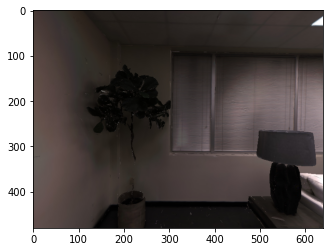

In [24]:
agent_pos = sim.pathfinder.get_random_navigable_point()
sim.agents[0].scene_node.translation = agent_pos
print(agent_pos)
#         assert raycast_results.hits[0].object_id == 0
obs = sim.get_sensor_observations()
plt.imshow(obs["color_sensor"])

In [25]:
# with habitat_sim.Simulator(hab_cfg) as sim:
obj_mgr = sim.get_object_template_manager()


agent_orientation_y = 0
sim.agents[0].scene_node.rotation = mn.Quaternion.rotation(
    mn.Deg(agent_orientation_y), mn.Vector3(0, 1.0, 0)
)

visual_sensor = sim._sensors['color_sensor']
scene_graph = sim.get_active_scene_graph()
scene_graph.set_default_render_camera_parameters(
    visual_sensor._sensor_object
)
render_camera = scene_graph.get_default_render_camera()
center_ray = render_camera.unproject(mn.Vector2i([300, 470]))

raycast_results = sim.cast_ray(center_ray, max_distance=1000)
print(center_ray.direction, center_ray.origin)
print(raycast_results.has_hits())
print(raycast_results.hits[0].ray_distance, raycast_results.hits[0].object_id)
# set agent to be at a random navigable point 

Vector(-0.050611, -0.584555, -0.809774) Vector(0.215958, -0.10025, 0.127071)
True
2.5522534269839525 -1
Vector(1, 0, 0) Vector(0, 0, 0)
True
1


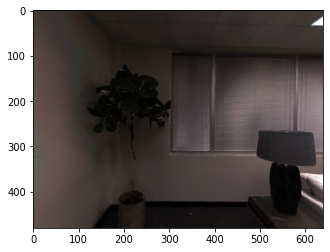

In [25]:
# only test this if we have a physics simulator and therefore a collision world
test_ray_1 = habitat_sim.geo.Ray()
test_ray_1.direction = mn.Vector3(1.0, 0, 0)
raycast_results = sim.cast_ray(test_ray_1)

print(test_ray_1.direction, test_ray_1.origin)
print(raycast_results.has_hits())
print(len(raycast_results.hits))


# add a primitive object to the world
cube_prim_handle = obj_mgr.get_template_handles("cube")[0]
cube_obj_id = sim.add_object_by_handle(cube_prim_handle)
set_object_in_front_of_agent(sim, cube_obj_id, -3.0, rot_offset=0)

raycast_results = sim.cast_ray(test_ray_1)
print(center_ray.direction, center_ray.origin)
print(raycast_results.has_hits())
print(raycast_results.hits[0].ray_distance, raycast_results.hits[0].object_id)
# set agent to be at a random navigable point 

In [ ]:
sim.close()